<a href="https://colab.research.google.com/github/jeffkblee/Image-Processing/blob/main/Jeffrey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/DODAS-TS/boto3sts
!pip install 'https://github.com/CYGNUS-RD/middleware/blob/master/midas/midaslib.tar.gz?raw=true'
!pip install git+https://github.com/CYGNUS-RD/cygno.git -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DODAS-TS/boto3sts to /tmp/pip-req-build-yu5azmoe
  Running command git clone -q https://github.com/DODAS-TS/boto3sts /tmp/pip-req-build-yu5azmoe
     |████████████████████████████████| 132 kB 30.8 MB/s 
     |████████████████████████████████| 8.9 MB 45.9 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 138 kB 44.8 MB/s 
     |████████████████████████████████| 856 kB 43.4 MB/s 
     |████████████████████████████████| 127 kB 51.5 MB/s 
  Created wheel for boto3sts: filename=boto3sts-0.0.8-py3-none-any.whl size=4677 sha256=e38fca5c9cf6c8f6b25d6a90dae15a622c214cedf7bbbee5dc53ee1b4e0b5ee9
  Stored in directory: /tmp/pip-ephem-wheel-cache-1l4b1zd4/wheels/d6/0e/a8/204df23fe4a288550d10cf9cf744ab143484e177e12982e424
Successfully built boto3sts
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1

Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains banks CAM0
Event # 19 of type ID 1 contains banks C

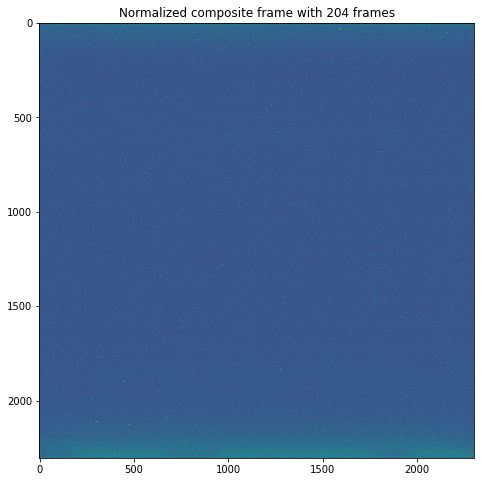

In [11]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy


# Reads pedestal images from an array and combines them.
# Generate a normalized composite image.
# Input: run number, path
# Output: normalized mean image, std of images, number of frames used to generate said image.
# Note: Needs manual checking of shape of array to set up "image" variable.
def ped_array(run, path = '/tmp/', cloud = True, tag = 'STD', verbose = True):

    mfile = cy.open_mid(run=run, path=path, cloud=cloud, tag=tag, verbose=verbose)
    foutm_name = (path+"mean_Run{:05d}".format(run)+"ped")
    fouts_name = (path+"sigma_Run{:05d}".format(run)+"ped")
    
    noFrame = 0
    #shape of the images array (23004,2304)
    m_image = np.zeros((2304,2304)) # average value of frames
    s_image = np.zeros((2304,2304)) # root mean square of frames
    for event in mfile:
        if event.header.is_midas_internal_event():
            if verbose: print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        if verbose: print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        if verbose: print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

        #if noFrame >= 3: break # Limit the frames produced for ease of debugging
        for bank_name, bank in event.banks.items():
            if bank_name=='DGH0': # PMTs wavform 
                header = cy.daq_dgz2header(bank)
                print (header)
                waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            if bank_name=='CAM0': # CAM image
                imageFrame, _, _ = cy.daq_cam2array(bank)
                m_image = np.add(m_image, imageFrame)
                s_image = np.add(s_image, imageFrame**2)
                # plt.figure(figsize=(8,8))
                # plt.imshow(imageFrame, vmin=95, vmax=115)
                # plt.title("Frame %s" %noFrame)
                # plt.show()
                noFrame += 1
            if bank_name=='INPT': # SLOW channels array
                slow = cy.daq_slow2array(bank)

    m_image = m_image/noFrame
    np.save(foutm_name, m_image)

    s_image = np.sqrt((s_image - m_image**2 * noFrame)/(noFrame - 1))
    np.save(fouts_name, s_image)
    # print(s_image)


    # plt.figure(figsize=(8,8))
    # plt.imshow(s_image, vmin=0, vmax=10)
    # plt.title("Normalized RMS frame with %s frames" %noFrame)
    # plt.show()

    return m_image, s_image, noFrame



# Run 250 Pedestal at LNF
pedestal_mean, pedestal_sigma, noFrame = ped_array(250, verbose = False)
plt.figure(figsize=(8,8))
plt.imshow(pedestal_mean, vmin=95, vmax=115)
#plt.imshow(pedestal_sigma, vmin=0, vmax=10)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()

Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains ba

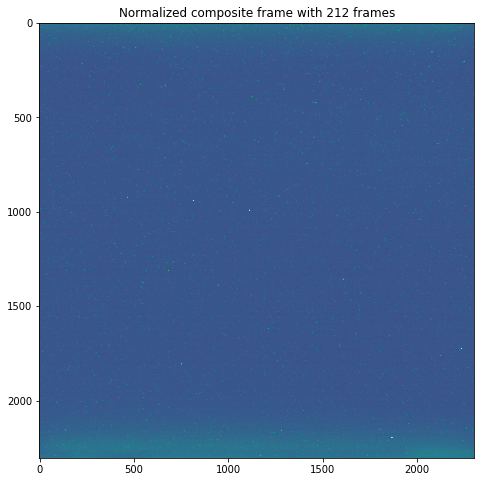

In [12]:
#Run 1403 Pedestal LNGS
pedestal_mean, pedestal_sigma, noFrame = ped_array(1403, verbose = False)
plt.figure(figsize=(8,8))
plt.imshow(pedestal_mean, vmin=95, vmax=115)
#plt.imshow(pedestal_sigma, vmin=0, vmax=10)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()

https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/STD/run01402.mid.gz
https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/STD/run01402.mid.gz
Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1655210605 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-06-14 12:43:25, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1655210605 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-06-14 12:43:25, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1655210605 containing banks DMND, MSRD
2022-06-14 12:43:25, banks DMND, MSRD
Event # 0 of type ID 1 contains banks CAM0
Received event with timestamp 1655210606 containing banks CAM0
2022-06-14 12:43:26, banks CAM0


file /tmp/run01402.mid.gz cached

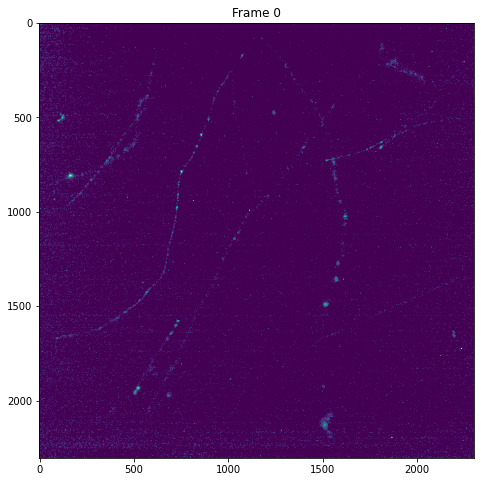

[[ -2.93627451   5.10784314  14.43627451 ...   4.54411765   4.02941176
   11.72058824]
 [-10.05882353   9.67156863   3.95098039 ...  20.18137255  -1.4754902
   -5.01470588]
 [  5.6372549   17.78431373   1.18137255 ...  -0.56372549  -6.45098039
    3.19607843]
 ...
 [  8.65196078  22.79901961  -9.04411765 ...   8.71568627  -0.48529412
   -2.00490196]
 [ 19.74509804  -4.65686275   1.08333333 ...   4.03431373  10.31862745
   -0.88235294]
 [  4.98039216  -7.51470588  -6.44117647 ...  -3.92156863  14.00980392
   10.92647059]]
Event # 1 of type ID 1 contains banks CAM0
Received event with timestamp 1655210607 containing banks CAM0
2022-06-14 12:43:27, banks CAM0


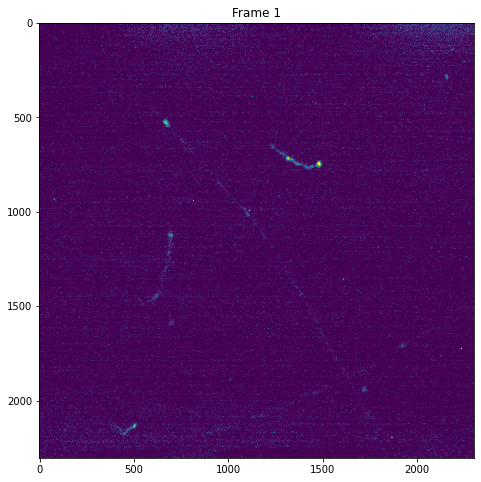

[[ 12.06372549   6.10784314  -4.56372549 ...  -4.45588235   4.02941176
    9.72058824]
 [-10.05882353  -3.32843137  -7.04901961 ...  -9.81862745   7.5245098
   -3.01470588]
 [-10.3627451   -3.21568627  -1.81862745 ...  -8.56372549   4.54901961
    4.19607843]
 ...
 [ -0.34803922   6.79901961   2.95588235 ...  -2.28431373  -7.48529412
    8.99509804]
 [ 10.74509804   2.34313725   5.08333333 ...   7.03431373   5.31862745
    7.11764706]
 [ 14.98039216  -6.51470588  -4.44117647 ...   3.07843137  -4.99019608
    6.92647059]]
Event # 2 of type ID 1 contains banks CAM0
Received event with timestamp 1655210608 containing banks CAM0
2022-06-14 12:43:28, banks CAM0


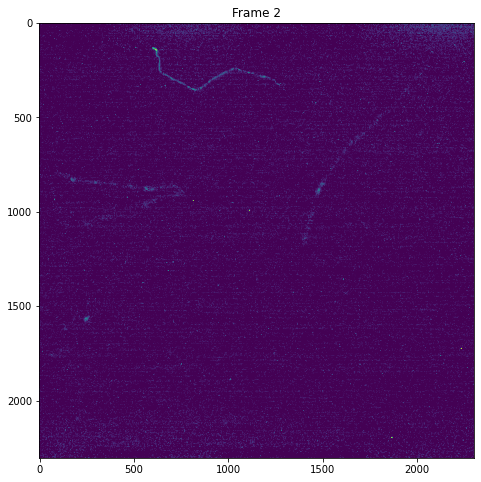

[[ -0.93627451   7.10784314  -1.56372549 ...  -8.45588235   2.02941176
   -2.27941176]
 [  4.94117647  -0.32843137  -4.04901961 ...  -3.81862745   6.5245098
    6.98529412]
 [ -9.3627451   -2.21568627  -4.81862745 ...   0.43627451  -3.45098039
   10.19607843]
 ...
 [ -0.34803922  15.79901961   7.95588235 ...  -1.28431373  -8.48529412
    3.99509804]
 [-10.25490196   2.34313725   7.08333333 ...   5.03431373   0.31862745
   -0.88235294]
 [ -2.01960784  -2.51470588  -7.44117647 ...  -1.92156863  -1.99019608
   -1.07352941]]
Event # 3 of type ID 1 contains banks CAM0
Received event with timestamp 1655210608 containing banks CAM0
2022-06-14 12:43:28, banks CAM0


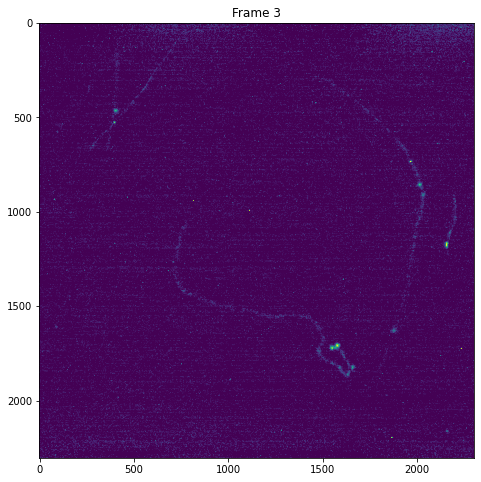

[[ 7.06372549e+00  6.10784314e+00 -9.56372549e+00 ...  1.54411765e+00
   4.02941176e+00  3.72058824e+00]
 [-1.05882353e+00  1.67156863e+00 -1.04901961e+00 ...  4.18137255e+00
   5.24509804e-01  7.98529412e+00]
 [ 4.63725490e+00  1.07843137e+01  1.81372549e-01 ...  2.43627451e+00
   5.54901961e+00  8.19607843e+00]
 ...
 [-3.48039216e-01 -2.20098039e+00 -3.04411765e+00 ...  7.15686275e-01
  -5.48529412e+00 -4.90196078e-03]
 [ 6.74509804e+00 -1.65686275e+00 -9.16666667e-01 ...  2.03431373e+00
   2.31862745e+00  2.11764706e+00]
 [ 8.98039216e+00 -7.51470588e+00 -1.44117647e+00 ... -1.92156863e+00
   8.00980392e+00 -7.07352941e+00]]
Event # 4 of type ID 1 contains banks CAM0
Received event with timestamp 1655210609 containing banks CAM0
2022-06-14 12:43:29, banks CAM0


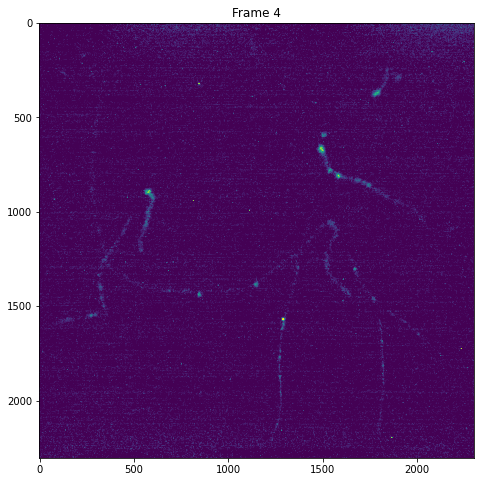

[[  4.06372549  -3.89215686   1.43627451 ... -10.45588235 -10.97058824
   -0.27941176]
 [ -3.05882353  -6.32843137  -9.04901961 ...   6.18137255 -10.4754902
   10.98529412]
 [ -4.3627451   -6.21568627   3.18137255 ...   7.43627451  -3.45098039
   -6.80392157]
 ...
 [  3.65196078   6.79901961  -3.04411765 ...  -8.28431373  -6.48529412
    9.99509804]
 [  4.74509804   4.34313725  -3.91666667 ...   5.03431373  -4.68137255
   -6.88235294]
 [  0.98039216   5.48529412  -5.44117647 ... -12.92156863  -8.99019608
    0.92647059]]
Event # 5 of type ID 1 contains banks CAM0
Received event with timestamp 1655210609 containing banks CAM0
2022-06-14 12:43:29, banks CAM0


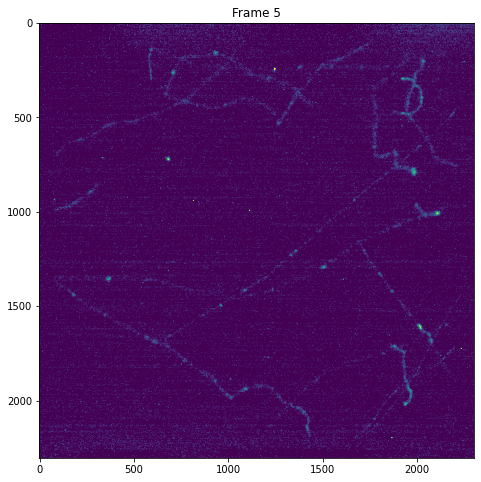

[[ 2.06372549e+00  1.07843137e-01 -2.56372549e+00 ...  5.44117647e-01
   3.02941176e+00  1.07205882e+01]
 [ 9.94117647e+00 -6.32843137e+00  1.59509804e+01 ... -5.81862745e+00
   3.52450980e+00  2.98529412e+00]
 [ 6.63725490e+00 -3.21568627e+00 -2.81862745e+00 ... -2.56372549e+00
   2.15490196e+01  2.19607843e+00]
 ...
 [ 2.65196078e+00 -4.20098039e+00 -3.04411765e+00 ...  5.71568627e+00
   3.51470588e+00 -4.90196078e-03]
 [-1.42549020e+01  1.53431373e+01  2.08333333e+00 ...  6.03431373e+00
  -6.81372549e-01  8.11764706e+00]
 [-1.96078431e-02 -5.14705882e-01  4.55882353e+00 ...  1.07843137e+00
  -1.99019608e+00  4.92647059e+00]]
Event # 6 of type ID 1 contains banks CAM0
Received event with timestamp 1655210611 containing banks CAM0
2022-06-14 12:43:31, banks CAM0


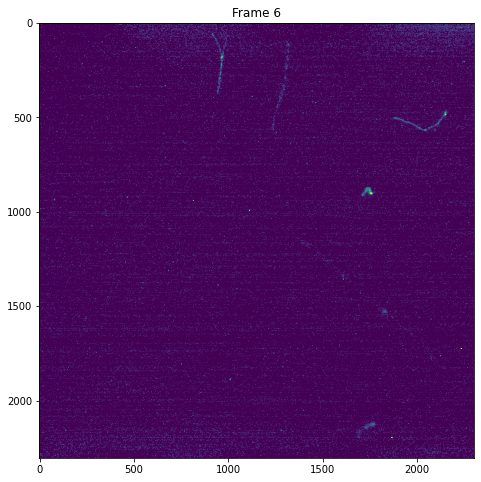

[[  8.06372549   6.10784314  14.43627451 ...  -0.45588235   4.02941176
   -3.27941176]
 [ -0.05882353  -2.32843137  -3.04901961 ...  21.18137255  -6.4754902
    0.98529412]
 [ -6.3627451    8.78431373  -0.81862745 ...   9.43627451  14.54901961
    6.19607843]
 ...
 [ -5.34803922   0.79901961  -2.04411765 ...   6.71568627  -9.48529412
    1.99509804]
 [ -2.25490196   3.34313725  -5.91666667 ...   5.03431373  -2.68137255
  -10.88235294]
 [ -5.01960784   2.48529412  -2.44117647 ...  -6.92156863  -2.99019608
   11.92647059]]
Event # 7 of type ID 1 contains banks CAM0
Received event with timestamp 1655210612 containing banks CAM0
2022-06-14 12:43:32, banks CAM0


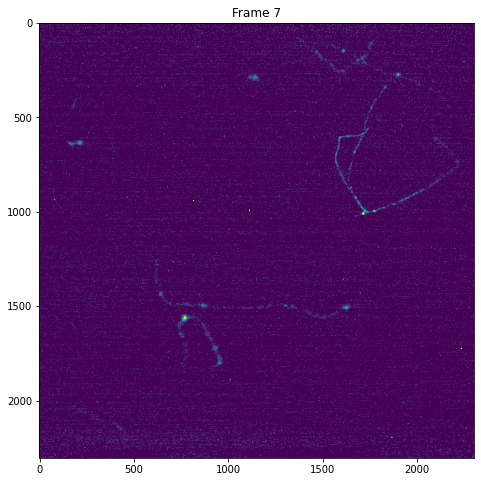

[[ 7.06372549 12.10784314  1.43627451 ...  5.54411765  2.02941176
   2.72058824]
 [-7.05882353 -6.32843137 -4.04901961 ... -4.81862745 14.5245098
  -1.01470588]
 [-2.3627451   7.78431373 -6.81862745 ... -1.56372549  1.54901961
  -8.80392157]
 ...
 [ 7.65196078 20.79901961  7.95588235 ...  2.71568627 -8.48529412
  12.99509804]
 [ 4.74509804 -1.65686275 10.08333333 ... -4.96568627  3.31862745
  10.11764706]
 [-1.01960784 -3.51470588 -7.44117647 ...  4.07843137  7.00980392
   7.92647059]]
Event # 8 of type ID 1 contains banks CAM0
Received event with timestamp 1655210614 containing banks CAM0
2022-06-14 12:43:34, banks CAM0


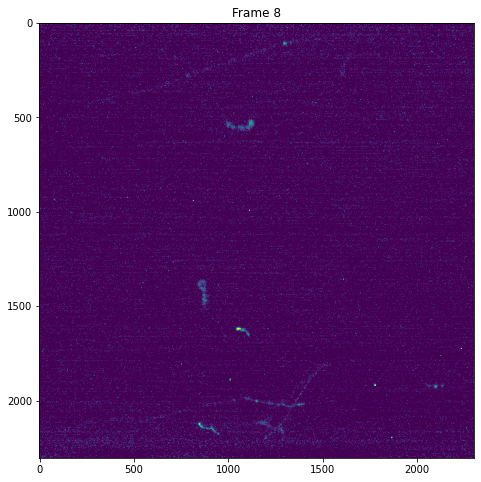

[[ -3.93627451  -5.89215686   1.43627451 ...  -0.45588235  12.02941176
   -6.27941176]
 [ -7.05882353  -8.32843137  -3.04901961 ...   7.18137255   2.5245098
   -3.01470588]
 [  3.6372549  -12.21568627   8.18137255 ...  11.43627451   6.54901961
   -5.80392157]
 ...
 [  3.65196078  -1.20098039  -2.04411765 ...   0.71568627 -10.48529412
    9.99509804]
 [  6.74509804  -3.65686275   3.08333333 ...   2.03431373  14.31862745
    1.11764706]
 [  7.98039216   9.48529412   0.55882353 ...   6.07843137   3.00980392
   -7.07352941]]
Event # 9 of type ID 1 contains banks CAM0
Received event with timestamp 1655210615 containing banks CAM0
2022-06-14 12:43:35, banks CAM0


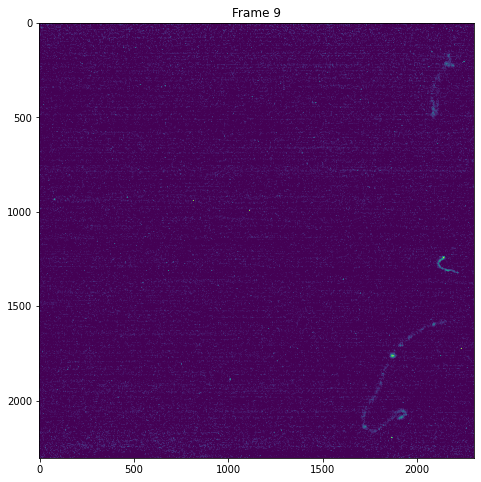

[[10.06372549  1.10784314  1.43627451 ... -2.45588235 -4.97058824
  -7.27941176]
 [-6.05882353 -5.32843137 -0.04901961 ... -6.81862745 -1.4754902
  -1.01470588]
 [-3.3627451  -5.21568627 -1.81862745 ...  1.43627451  2.54901961
  10.19607843]
 ...
 [ 0.65196078  6.79901961 -4.04411765 ... -8.28431373 -4.48529412
   3.99509804]
 [ 4.74509804  3.34313725 12.08333333 ...  0.03431373 -2.68137255
  -5.88235294]
 [-8.01960784 -7.51470588 -0.44117647 ...  0.07843137  6.00980392
   8.92647059]]
Event # 10 of type ID 1 contains banks CAM0
Received event with timestamp 1655210617 containing banks CAM0
2022-06-14 12:43:37, banks CAM0


0

In [23]:

import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy

# Reads images from an array and subtracts the pedestal.
# Input: run number, path
# Output: images minus pedestal
# Note: Needs manual insertion of path for pedestal
def ima_array(run, path = '/tmp/', cloud = True, tag = 'STD', verbose = True):

    mfile = cy.open_mid(run=run, path=path, cloud=cloud, tag=tag, verbose=verbose)


    ped = np.load("/tmp/mean_Run00250.npy") #Input pedestal associated with run.
    noFrame = 0
    #shape of the images array (23004,2304)
    image = np.zeros((2304,2304)) # average value of frames
    for event in mfile:
        if event.header.is_midas_internal_event():
            if verbose: print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        if verbose: print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        if verbose: print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

        if noFrame >= 10: break # Limit the frames produced for ease of debugging
        for bank_name, bank in event.banks.items():
            if bank_name=='DGH0': # PMTs wavform 
                header = cy.daq_dgz2header(bank)
                print (header)
                waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            if bank_name=='CAM0': # CAM image
                if noFrame >= 10: break
                image, _, _ = cy.daq_cam2array(bank)
                image = np.subtract(image, ped)
                plt.figure(figsize=(8,8))
                plt.imshow(image, vmin=0, vmax=20)
                plt.title("Frame %s" %noFrame)
                plt.show()
                noFrame += 1
                print(image)
            if bank_name=='INPT': # SLOW channels array
                slow = cy.daq_slow2array(bank)


    # print(s_image)


    # plt.figure(figsize=(8,8))
    # plt.imshow(s_image, vmin=0, vmax=10)
    # plt.title("Normalized RMS frame with %s frames" %noFrame)
    # plt.show()

    return 0


# Run 1402 Image LNGS
ima_array(1402)

In [ ]:
# Run 249 Image LNF
pedestal_mean, pedestal_sigma, noFrame = ped_array(249, verbose = False)
plt.figure(figsize=(8,8))
plt.imshow(pedestal_mean, vmin=95, vmax=115)
#plt.imshow(pedestal_sigma, vmin=0, vmax=10)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()